<a href="https://colab.research.google.com/github/AmirAlemo/CartPole-solution-using-deepRL/blob/main/RLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
#required Python dependencies
pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
#required system dependencies
apt-get install -y xvfb x11-utils

In [ ]:
!pip install gym[classic_control]==0.21.*

In [8]:
import os
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython import display as ipythondisplay


#Hyperparameters

learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32
video_every = 25
print_every = 5


class ReplayBuffer():#Experience Buffer

   def __init__(self):
     self.buffer = collections.deque(maxlen=buffer_limit) #We set an upper limit for our running experience memory(deque) as buffer_limit


   def put(self,transition):#Adding transition as Tuple into our experience buffer
     self.buffer.append(transition)


   def sample(self, n):#Random generated transitions
       mini_batch = random.sample(self.buffer, n)
       s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

       for  transition in mini_batch:
         s, a, r, s_prime, done_mask = transition
         s_lst.append(s)
         a_lst.append([a])
         r_lst.append([r])
         s_prime_lst.append(s_prime)
         done_mask_lst.append([done_mask])

         return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
         torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
         torch.tensor(done_mask_lst)

   def size(self):#Returns the length of our memory deque
    return len(self.buffer)

class QNetwork(nn.Module):

 def __init__(self, insize, outsize): #Defining a fully connected 3-layer neural network
  super(QNetwork, self).__init__()
  self.fc1 = nn.Linear(insize, 256)
  self.fc2 = nn.Linear(256, 84)
  self.fc3 = nn.Linear(84, outsize)


 def forward(self, x):#Producing ALL of the action scores in parallel
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x


 def sample_action(self, obs, epsilon):#Producing a random action every once in a while!
      out = self.forward(obs)
      coin = random.random()
      if coin < epsilon:
        return random.randint(0,1)
      else:
          return out.argmax().item()#Max over all of our action scores


def train(q, q_target, memory, optimizer):#Training loop to run 10 times per iteration
      for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma*max_q_prime*done_mask
        loss = F.smooth_l1_loss(q_a, target)
         #optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [9]:
from pyvirtualdisplay import Display#Display buffer
display = Display(visible=False, size=(1400,900))
display.start()

In [10]:
!echo $DISPLAY#Test if Display is available

:0#Test if Display is available


In [11]:
#Setting up the training environment and recording a video from the training sesseion every 5 episodes
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, "/video", video_callable=lambda episode_id: (episode_id%video_every)==0, force = True)


In [12]:
env.reset()

array([ 0.01392667, -0.02733683,  0.04163995, -0.03474056], dtype=float32)

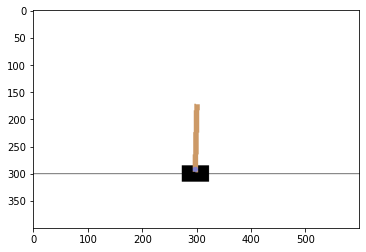

In [12]:
plt.imshow(env.render(mode='rgb_array'))

In [ ]:
#Train!
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)


q = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
q_target = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()


score = 0.0
marking = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)


for n_episode in range(3001):
   epsilon = max(0.01, 0.08 - 0.01*(n_episode/200))#Linear annealing from 8% to 1%
   s = env.reset()
   done = False
   score = 0.0

   while True:

     a = q.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
     s_prime, r, done, info = env.step(a)
     done_mask = 0.0 if done else 1.0
     memory.put((s, a, r/200, s_prime, done_mask))#Generating samples (state, action, reward, future next step, check if done) and plugging them into memory
     s = s_prime

     score += r#Piling on the rewards as we go forward
     if done:
       break




   if memory.size()>2000:#Size is selected 2000 just to even the distribution
       train(q, q_target, memory, optimizer)


   marking.append(score)
   if n_episode%100 == 0:
      print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
          n_episode, score, np.array(marking).mean(), np.array(marking).std()))
      marking = []


   if n_episode%print_every == 0 and n_episode != 0:
      q_target.load_state_dict(q.state_dict())
      print("episode: {}, score :{:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))